In [ ]:
schaefer_atlas = datasets.fetch_atlas_schaefer_2018(n_rois=200, resolution_mm=2)

In [ ]:
# clears all cache directories in a given directory
import os
import shutil
from pathlib import Path

def find_and_analyze_caches(root_dir):
    """Find all cache directories and analyze their sizes"""
    cache_patterns = [
        'nilearn_cache',
        '__pycache__',
        '.pytest_cache',
        'joblib',
        '.cache'
    ]
    
    total_size = 0
    found_caches = []
    
    for path, dirs, files in os.walk(root_dir):
        for dir_name in dirs:
            if any(cache_pattern in dir_name.lower() for cache_pattern in cache_patterns):
                full_path = os.path.join(path, dir_name)
                size_mb = sum(f.stat().st_size for f in Path(full_path).glob('**/*') if f.is_file()) / (1024 * 1024)
                found_caches.append((full_path, size_mb))
                total_size += size_mb
    
    return found_caches, total_size

def clean_all_caches(root_dir, confirm=True):
    """Remove all cache directories"""
    found_caches, total_size = find_and_analyze_caches(root_dir)
    
    print(f"\nFound {len(found_caches)} cache directories:")
    for path, size in found_caches:
        print(f"{path}: {size:.2f} MB")
    print(f"\nTotal cache size: {total_size:.2f} MB")
    
    if confirm:
        response = input("\nDo you want to delete all these cache directories? (yes/no): ")
        if response.lower() != 'yes':
            print("Aborted cache cleaning")
            return
    
    for path, _ in found_caches:
        try:
            shutil.rmtree(path)
            print(f"Deleted: {path}")
        except Exception as e:
            print(f"Error deleting {path}: {e}")

# Use it (replace with your repository path):
repo_path = '/user_data/csimmon2/git_repos/ptoc'
clean_all_caches(repo_path)

In [ ]:
#creates connectivity matrix
import os
import sys
import pandas as pd
import numpy as np
import nibabel as nib
from nilearn import image, input_data, datasets
from nilearn.maskers import NiftiLabelsMasker
from nilearn.connectome import ConnectivityMeasure
import logging

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Import your parameters
curr_dir = f'/user_data/csimmon2/git_repos/ptoc'
sys.path.insert(0, curr_dir)
import ptoc_params as params

# Set up directories and parameters
study = 'ptoc'
study_dir = f"/lab_data/behrmannlab/vlad/{study}"
raw_dir = params.raw_dir
results_dir = '/user_data/csimmon2/git_repos/ptoc/results'

# Load subject information
sub_info = pd.read_csv(f'{curr_dir}/sub_info.csv')
subjects_to_skip = ['sub-025', 'sub-038']
subs = sub_info[(sub_info['group'] == 'control') & (~sub_info['sub'].isin(subjects_to_skip))]['sub'].tolist()
#sub_info = sub_info[sub_info['group'] == 'control']
#sub_info = sub_info[sub_info['sub'] != 'sub-025'] #to exlude sub 25
#subs = sub_info['sub'].tolist()
#subs = ['sub-025']

run_num = 3
runs = list(range(1, run_num + 1))

# Define the number of ROIs for the Schaefer atlas
n_rois = 200  # You can adjust this value as needed

def apply_schaefer_atlas(subject_data, atlas_img, n_rois):
    # Resample atlas to subject space
    resampled_atlas = image.resample_to_img(atlas_img, subject_data, interpolation='nearest') # consider the interpolation method 
    
    # Extract time series data ##to check
    atlas_masker = input_data.NiftiLabelsMasker(labels_img=resampled_atlas, 
                                                standardize=True,
                                                memory='nilearn_cache', 
                                                verbose=0)
    time_series = atlas_masker.fit_transform(subject_data)
    
    return time_series

def create_connectivity_matrix(ss):
    logging.info(f"Processing subject: {ss}")
    
    # Load Schaefer atlas
    atlas = datasets.fetch_atlas_schaefer_2018(n_rois=n_rois, yeo_networks=7, resolution_mm=2) ###7???
    atlas_img = atlas.maps
    
    all_runs_data = []
    
    for rn in runs:
        # Load subject data for this run
        run_path = f'{raw_dir}/{ss}/ses-01/derivatives/fsl/loc/run-0{rn}/1stLevel.feat/filtered_func_data_reg.nii.gz'
        if not os.path.exists(run_path):
            logging.warning(f'Run data not found: {run_path}')
            continue
        
        subject_img = nib.load(run_path)
        
        # Apply Schaefer atlas and extract time series
        run_data = apply_schaefer_atlas(subject_img, atlas_img, n_rois)
        all_runs_data.append(run_data)
    
    if not all_runs_data:
        logging.warning(f'No valid run data found for subject {ss}')
        return None
    
    # Concatenate runs
    full_time_series = np.concatenate(all_runs_data, axis=0)
    
    # Compute connectivity matrix
    correlation_measure = ConnectivityMeasure(kind='correlation')
    connectivity_matrix = correlation_measure.fit_transform([full_time_series])[0]
    
    return connectivity_matrix

def main():
    for ss in subs:
        connectivity_matrix = create_connectivity_matrix(ss)
        if connectivity_matrix is not None:
            # Save the connectivity matrix
            output_dir = f'{results_dir}/connectivity_matrices'
            os.makedirs(output_dir, exist_ok=True)
            np.save(f'{output_dir}/{ss}_connectivity_matrix.npy', connectivity_matrix)
            logging.info(f'Saved connectivity matrix for {ss}')

if __name__ == "__main__":
    main()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import pandas as pd
import logging

# Set up logging and paths
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# Set up directory structure
curr_dir = f'/user_data/csimmon2/git_repos/ptoc'
sys.path.insert(0, curr_dir)
import ptoc_params as params

study = 'ptoc'
study_dir = f"/lab_data/behrmannlab/vlad/{study}"
raw_dir = params.raw_dir
results_dir = '/user_data/csimmon2/git_repos/ptoc/results'
connectivity_dir = os.path.join(curr_dir, 'results', 'connectivity_matrices')  # Updated path

def analyze_connectivity_matrix(file_path, sub_id):
    logger.info(f"Starting analysis for subject: {sub_id}")
    try:
        # Load and verify matrix
        matrix = np.load(file_path)
        logger.info(f"Successfully loaded matrix for {sub_id}")
        logger.info(f"Matrix shape: {matrix.shape}")
        logger.info(f"Value range: {matrix.min():.3f} to {matrix.max():.3f}")
        logger.info(f"Mean connectivity: {matrix.mean():.3f}")

        # Verify symmetry
        is_symmetric = np.allclose(matrix, matrix.T)
        logger.info(f"Matrix symmetry check: {is_symmetric}")

        # Plot improved visualization
        plt.figure(figsize=(15, 12))

        # Network boundaries for Schaefer 200-7Network
        networks = [0, 22, 50, 75, 110, 140, 170, 200]
        network_labels = [
            'DefaultMode',
            'Control',
            'Limbic',
            'SalVentAttn',
            'DorsAttn',
            'SomMot',
            'Visual'
        ]

        # Create heatmap
        sns.heatmap(matrix,
                    cmap='RdBu_r',
                    center=0,
                    square=True,
                    xticklabels=False,
                    yticklabels=False,
                    cbar_kws={'label': 'Correlation'})

        # Add network boundaries
        for idx in networks:
            plt.axhline(y=idx, color='black', linewidth=1)
            plt.axvline(x=idx, color='black', linewidth=1)

        # Add network labels
        for i in range(len(networks)-1):
            mid_point = (networks[i] + networks[i+1]) // 2
            plt.text(-10, mid_point, network_labels[i],
                    rotation=90, verticalalignment='center')

        plt.title(f'Brain Connectivity Matrix (Schaefer 200 ROIs)\nSubject: {sub_id}')

        # Add network-wise correlation information
        logger.info(f"Calculating network-wise correlations for {sub_id}")
        network_correlations = {}
        for i in range(len(networks)-1):
            network_data = matrix[networks[i]:networks[i+1], networks[i]:networks[i+1]]
            mean_corr = np.mean(network_data)
            network_correlations[network_labels[i]] = mean_corr
            logger.info(f"{network_labels[i]}: {mean_corr:.3f}")

        # Save matrix visualization
        figure_dir = os.path.join(results_dir, 'figures')
        os.makedirs(figure_dir, exist_ok=True)
        plt.tight_layout()
        matrix_fig_path = os.path.join(figure_dir, f'{sub_id}_connectivity_matrix.png')
        plt.savefig(matrix_fig_path)
        logger.info(f"Saved matrix visualization to {matrix_fig_path}")
        plt.close()

        # Create network-level connectivity
        network_matrix = np.zeros((7, 7))
        for i in range(len(networks)-1):
            for j in range(len(networks)-1):
                block = matrix[networks[i]:networks[i+1], networks[j]:networks[j+1]]
                network_matrix[i, j] = np.mean(block)

        # Plot network-level connectivity
        plt.figure(figsize=(10, 8))
        sns.heatmap(network_matrix,
                    cmap='RdBu_r',
                    center=0,
                    square=True,
                    xticklabels=network_labels,
                    yticklabels=network_labels)
        plt.title(f'Network-Level Connectivity\nSubject: {sub_id}')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        
        network_fig_path = os.path.join(figure_dir, f'{sub_id}_network_connectivity.png')
        plt.savefig(network_fig_path)
        logger.info(f"Saved network visualization to {network_fig_path}")
        plt.close()

        return network_correlations

    except Exception as e:
        logger.error(f"Error processing subject {sub_id}: {str(e)}")
        return None

def create_group_visualizations(all_matrices, sub_ids, output_dir):
    """
    Create group-level visualizations of connectivity patterns.
    
    Parameters:
    all_matrices: list of subject connectivity matrices
    sub_ids: list of subject IDs
    output_dir: directory to save visualizations
    """
    logger.info("Creating group-level visualizations")
    
    # Convert to numpy array for easier manipulation
    matrices_array = np.array(all_matrices)
    
    # Calculate mean and standard deviation across subjects
    mean_matrix = np.mean(matrices_array, axis=0)
    std_matrix = np.std(matrices_array, axis=0)
    cv_matrix = std_matrix / np.abs(mean_matrix)  # Coefficient of variation
    
    # Network boundaries and labels
    networks = [0, 22, 50, 75, 110, 140, 170, 200]
    network_labels = [
        'DefaultMode',
        'Control',
        'Limbic',
        'SalVentAttn',
        'DorsAttn',
        'SomMot',
        'Visual'
    ]

    # 1. Mean Connectivity Matrix
    plt.figure(figsize=(15, 12))
    sns.heatmap(mean_matrix,
                cmap='RdBu_r',
                center=0,
                square=True,
                xticklabels=False,
                yticklabels=False,
                cbar_kws={'label': 'Mean Correlation'})
    
    # Add network boundaries
    for idx in networks:
        plt.axhline(y=idx, color='black', linewidth=1)
        plt.axvline(x=idx, color='black', linewidth=1)
    
    # Add network labels
    for i in range(len(networks)-1):
        mid_point = (networks[i] + networks[i+1]) // 2
        plt.text(-10, mid_point, network_labels[i],
                rotation=90, verticalalignment='center')
    
    plt.title('Group Average Connectivity Matrix')
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'group_mean_connectivity.png'))
    plt.close()

    # 2. Standard Deviation Matrix
    plt.figure(figsize=(15, 12))
    sns.heatmap(std_matrix,
                cmap='viridis',
                square=True,
                xticklabels=False,
                yticklabels=False,
                cbar_kws={'label': 'Standard Deviation'})
    
    for idx in networks:
        plt.axhline(y=idx, color='black', linewidth=1)
        plt.axvline(x=idx, color='black', linewidth=1)
    
    for i in range(len(networks)-1):
        mid_point = (networks[i] + networks[i+1]) // 2
        plt.text(-10, mid_point, network_labels[i],
                rotation=90, verticalalignment='center')
    
    plt.title('Connectivity Variability Across Subjects')
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'group_connectivity_std.png'))
    plt.close()

    # 3. Network-level group analysis
    network_means = np.zeros((7, 7))
    network_stds = np.zeros((7, 7))
    
    for i in range(len(networks)-1):
        for j in range(len(networks)-1):
            block = mean_matrix[networks[i]:networks[i+1], networks[j]:networks[j+1]]
            network_means[i, j] = np.mean(block)
            
            block_std = std_matrix[networks[i]:networks[i+1], networks[j]:networks[j+1]]
            network_stds[i, j] = np.mean(block_std)

    # Plot network-level mean connectivity
    plt.figure(figsize=(12, 10))
    sns.heatmap(network_means,
                cmap='RdBu_r',
                center=0,
                square=True,
                xticklabels=network_labels,
                yticklabels=network_labels,
                annot=True,
                fmt='.2f')
    plt.title('Group Average Network-Level Connectivity')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'group_network_mean.png'))
    plt.close()

    # Plot network-level variability
    plt.figure(figsize=(12, 10))
    sns.heatmap(network_stds,
                cmap='viridis',
                square=True,
                xticklabels=network_labels,
                yticklabels=network_labels,
                annot=True,
                fmt='.2f')
    plt.title('Network-Level Connectivity Variability')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'group_network_std.png'))
    plt.close()

    # 4. Distribution plots for each network's internal connectivity
    plt.figure(figsize=(15, 8))
    network_internal_conn = []
    network_names = []
    
    for i in range(len(networks)-1):
        for matrix in matrices_array:
            block = matrix[networks[i]:networks[i+1], networks[i]:networks[i+1]]
            mean_conn = np.mean(block)
            network_internal_conn.append(mean_conn)
            network_names.append(network_labels[i])
    
    df_dist = pd.DataFrame({
        'Network': network_names,
        'Internal Connectivity': network_internal_conn
    })
    
    sns.violinplot(data=df_dist, x='Network', y='Internal Connectivity')
    plt.xticks(rotation=45, ha='right')
    plt.title('Distribution of Internal Network Connectivity Across Subjects')
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'network_internal_connectivity_distribution.png'))
    plt.close()

    return mean_matrix, std_matrix, network_means, network_stds

def process_all_subjects(sub_info_path):
    logger.info("Starting group analysis")
    
    # Load subject information
    sub_info = pd.read_csv(sub_info_path)
    sub_info = sub_info[sub_info['group'] == 'control']
    logger.info(f"Loaded information for {len(sub_info)} subjects")
    
    subs = sub_info['sub'].tolist()

    # Create results directories
    figure_dir = os.path.join(results_dir, 'figures')
    group_dir = os.path.join(figure_dir, 'group_level')
    os.makedirs(group_dir, exist_ok=True)
    os.makedirs(os.path.join(results_dir, 'connectivity_data'), exist_ok=True)

    # Lists to store matrices and correlations
    all_matrices = []
    all_correlations = {}
    processed_subs = []

    # Process each subject
    for sub in subs:
        logger.info(f"Processing subject: {sub}")
        file_path = os.path.join(connectivity_dir, f'{sub}_connectivity_matrix.npy')
        
        if os.path.exists(file_path):
            matrix = np.load(file_path)
            correlations = analyze_connectivity_matrix(file_path, sub)
            if correlations:
                all_matrices.append(matrix)
                all_correlations[sub] = correlations
                processed_subs.append(sub)
        else:
            logger.warning(f"File not found for subject {sub}: {file_path}")

    # Create group visualizations if we have data
    if all_matrices:
        logger.info("Creating group-level visualizations")
        mean_matrix, std_matrix, network_means, network_stds = create_group_visualizations(
            all_matrices, processed_subs, group_dir)
        
        # Save group-level matrices
        np.save(os.path.join(results_dir, 'connectivity_data', 'group_mean_matrix.npy'), mean_matrix)
        np.save(os.path.join(results_dir, 'connectivity_data', 'group_std_matrix.npy'), std_matrix)
        
        # Create and save correlation summary
        correlation_df = pd.DataFrame.from_dict(all_correlations, orient='index')
        output_path = os.path.join(results_dir, 'connectivity_data', 'network_correlations_summary.csv')
        correlation_df.to_csv(output_path)
        logger.info(f"Saved correlation summary to {output_path}")
        
        # Calculate and save group-level statistics
        stats_summary = correlation_df.describe()
        stats_output_path = os.path.join(results_dir, 'connectivity_data', 'group_level_statistics.csv')
        stats_summary.to_csv(stats_output_path)
        logger.info(f"Saved group-level statistics to {stats_output_path}")
        
        return correlation_df
    else:
        logger.error("No valid data processed")
        return None

if __name__ == "__main__":
    # Set up paths
    sub_info_path = os.path.join(curr_dir, 'sub_info.csv') 
    
    # Run analysis
    logger.info("Starting connectivity analysis pipeline")
    correlation_df = process_all_subjects(sub_info_path)
    
    if correlation_df is not None:
        logger.info("Analysis completed successfully")
    else:
        logger.error("Analysis failed to complete")

Matrix Diagnostics:
Shape: (200, 200)
Value range: -0.631 to 1.000
Mean connectivity: 0.131
Matrix is symmetric: True

Network-wise average internal correlations:
DefaultMode: 0.182
Control: 0.225
Limbic: 0.129
SalVentAttn: 0.164
DorsAttn: 0.205
SomMot: 0.157
Visual: 0.166


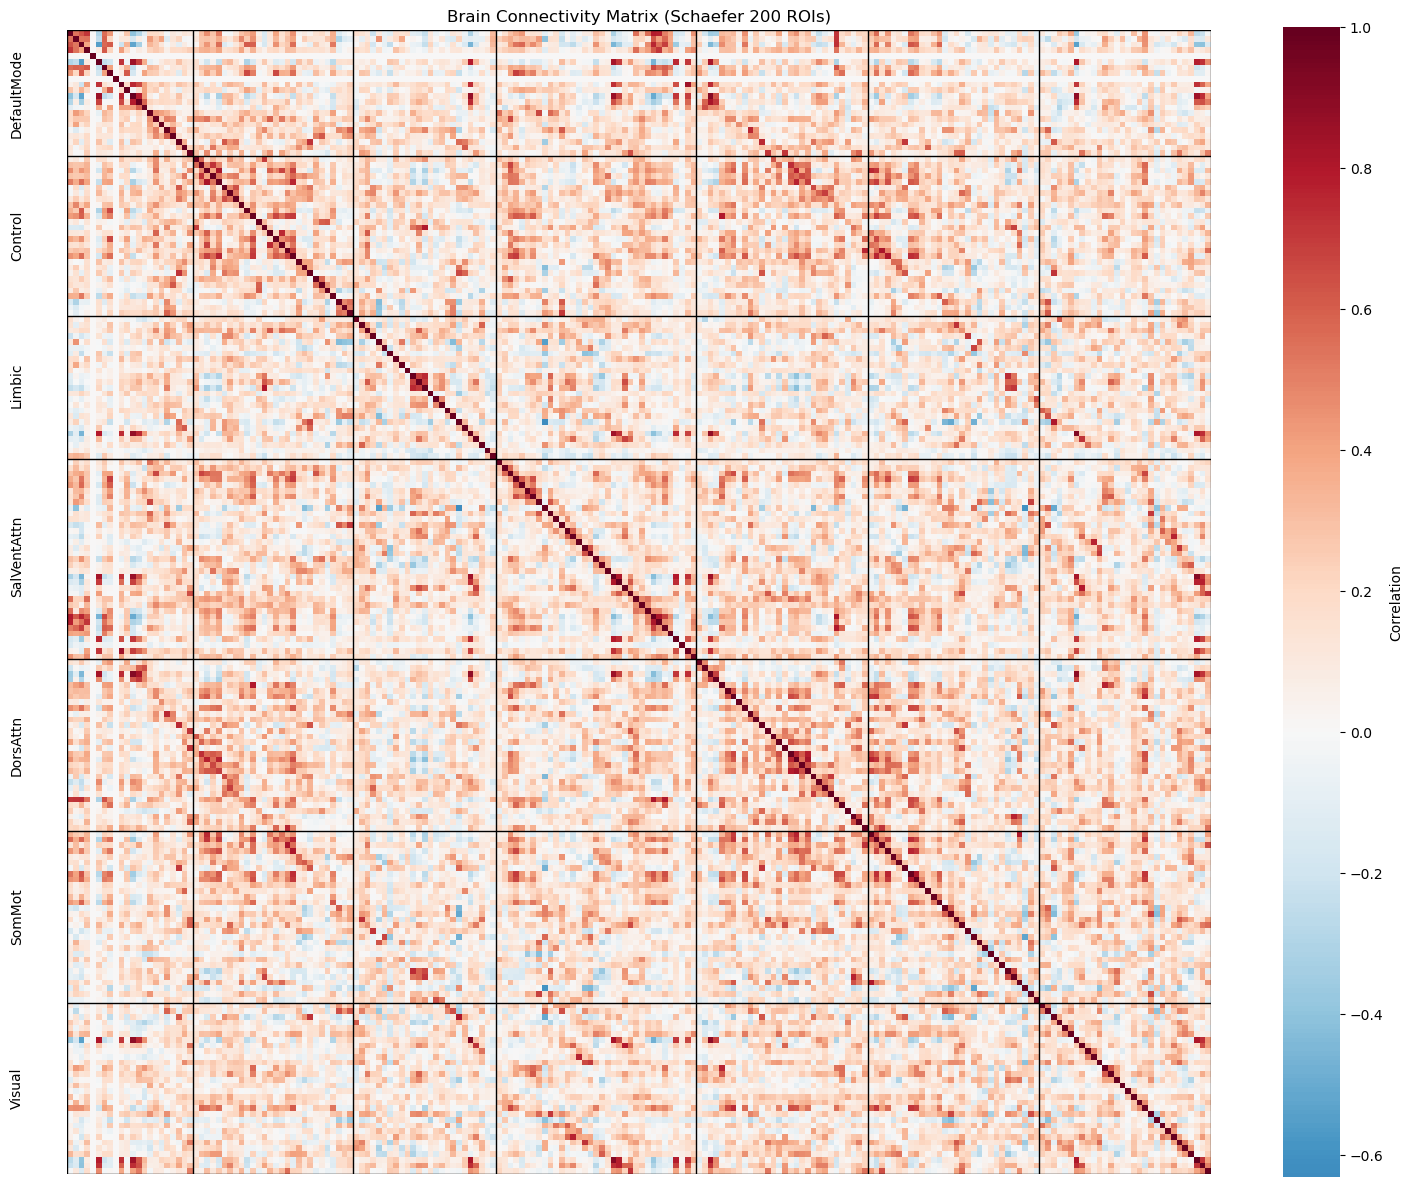

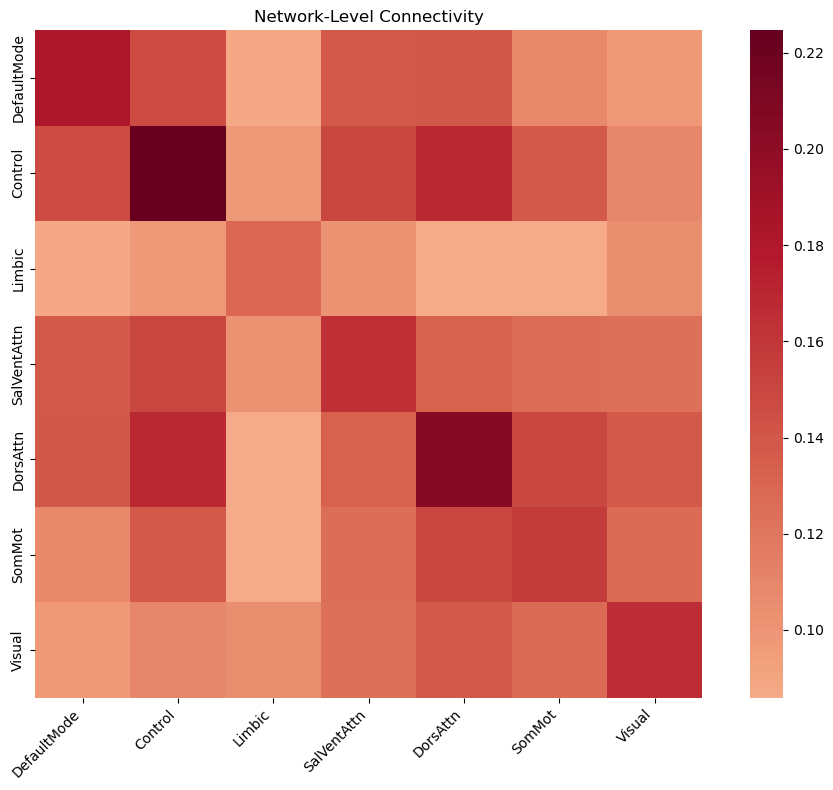

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_connectivity_matrix(file_path):
    # Load and verify matrix
    matrix = np.load(file_path)
    print(f"Matrix Diagnostics:")
    print(f"Shape: {matrix.shape}")
    print(f"Value range: {matrix.min():.3f} to {matrix.max():.3f}")
    print(f"Mean connectivity: {matrix.mean():.3f}")
    
    # Verify symmetry
    is_symmetric = np.allclose(matrix, matrix.T)
    print(f"Matrix is symmetric: {is_symmetric}")
    
    # Plot improved visualization
    plt.figure(figsize=(15, 12))
    
    # Network boundaries for Schaefer 200-7Network
    networks = [0, 22, 50, 75, 110, 140, 170, 200]
    network_labels = [
        'DefaultMode',
        'Control',
        'Limbic',
        'SalVentAttn',
        'DorsAttn',
        'SomMot',
        'Visual'
    ]
    
    # Create heatmap
    sns.heatmap(matrix,
                cmap='RdBu_r',
                center=0,
                square=True,
                xticklabels=False,  # Remove for clarity
                yticklabels=False,
                cbar_kws={'label': 'Correlation'})
    
    # Add network boundaries
    for idx in networks:
        plt.axhline(y=idx, color='black', linewidth=1)
        plt.axvline(x=idx, color='black', linewidth=1)
    
    # Add network labels
    for i in range(len(networks)-1):
        mid_point = (networks[i] + networks[i+1]) // 2
        plt.text(-10, mid_point, network_labels[i], 
                rotation=90, verticalalignment='center')
    
    plt.title('Brain Connectivity Matrix (Schaefer 200 ROIs)')
    
    # Add network-wise correlation information
    print("\nNetwork-wise average internal correlations:")
    for i in range(len(networks)-1):
        network_data = matrix[networks[i]:networks[i+1], networks[i]:networks[i+1]]
        mean_corr = np.mean(network_data)
        print(f"{network_labels[i]}: {mean_corr:.3f}")
    
    plt.tight_layout()
    plt.show()
    
    # Create a simplified version showing network-level connectivity
    network_matrix = np.zeros((7, 7))
    for i in range(len(networks)-1):
        for j in range(len(networks)-1):
            block = matrix[networks[i]:networks[i+1], networks[j]:networks[j+1]]
            network_matrix[i, j] = np.mean(block)
    
    # Plot network-level connectivity
    plt.figure(figsize=(10, 8))
    sns.heatmap(network_matrix,
                cmap='RdBu_r',
                center=0,
                square=True,
                xticklabels=network_labels,
                yticklabels=network_labels)
    plt.title('Network-Level Connectivity')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Run the analysis
file_path = 'results/connectivity_matrices/sub-025_connectivity_matrix.npy'
analyze_connectivity_matrix(file_path)

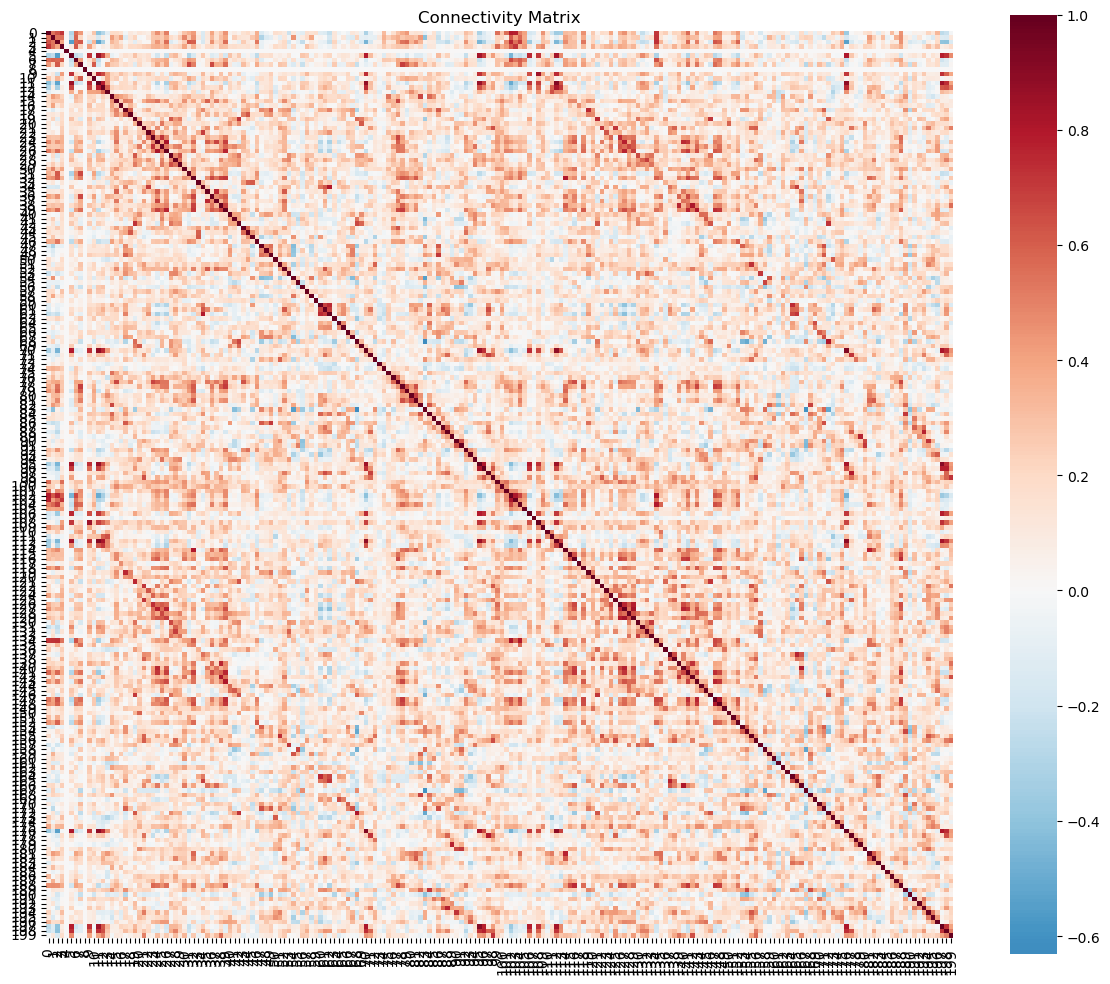

Matrix shape: (200, 200)

Matrix values range: -0.63092643 to 1.0

First few rows and columns:
[[1.    0.543 0.629 0.72  0.   ]
 [0.543 1.    0.532 0.539 0.   ]
 [0.629 0.532 1.    0.392 0.   ]
 [0.72  0.539 0.392 1.    0.   ]
 [0.    0.    0.    0.    1.   ]]


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

file_path = 'results/connectivity_matrices/sub-025_connectivity_matrix.npy'

def view_connectivity_matrix(file_path):
    # Load the connectivity matrix
    matrix = np.load(file_path)
    
    # Create a figure with a larger size
    plt.figure(figsize=(12, 10))
    
    # Create heatmap using seaborn
    sns.heatmap(matrix, 
                cmap='RdBu_r',  # Red-Blue diverging colormap
                center=0,       # Center the colormap at 0
                square=True,    # Make the plot square
                xticklabels=True,
                yticklabels=True)
    
    plt.title('Connectivity Matrix')
    plt.tight_layout()
    plt.show()

# Use the function
file_path = 'results/connectivity_matrices/sub-025_connectivity_matrix.npy'
view_connectivity_matrix(file_path)

# If you want to see the raw numbers:
matrix = np.load(file_path)
print("Matrix shape:", matrix.shape)
print("\nMatrix values range:", np.min(matrix), "to", np.max(matrix))
print("\nFirst few rows and columns:")
np.set_printoptions(precision=3, suppress=True)
print(matrix[:5, :5])  # Show first 5x5 elements

ValueError: 'adjacency_matrix' is supposed to have shape (n, n). Its shape was ()

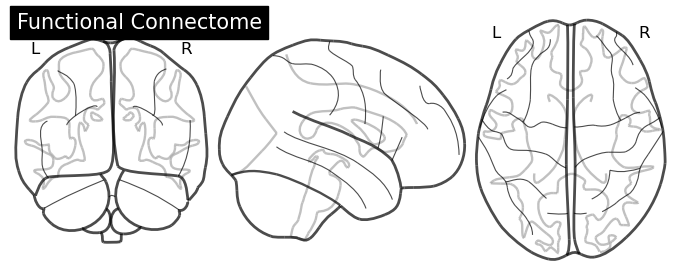

In [9]:
from nilearn import plotting

def visualize_connectome(connectivity_matrix, atlas):
    coords = plotting.find_parcellation_cut_coords(labels_img=atlas.maps)
    plotting.plot_connectome(connectivity_matrix, coords, 
                             title='Functional Connectome')
    plt.savefig(f'{output_dir}/{ss}_connectome.png')
    #plt.close()

connectivity_matrix = f'results/connectivity_matrices/sub-025_connectivity_matrix.npy'
atlas = datasets.fetch_atlas_schaefer_2018(n_rois=200, resolution_mm=2)

visualize_connectome(connectivity_matrix, atlas)
# Call this function after creating the connectivity matrix in your main function

NameError: name 'plt' is not defined

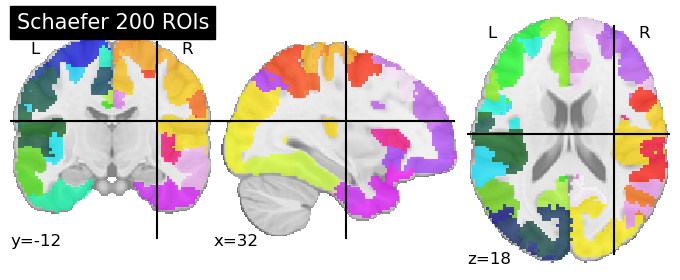

In [4]:
from nilearn import plotting

def visualize_atlas(atlas):
    plotting.plot_roi(atlas.maps, title='Schaefer 200 ROIs')
    plt.savefig(f'{output_dir}/schaefer_200_atlas.png')
    #plt.close()

# Call this function after loading the atlas
atlas = datasets.fetch_atlas_schaefer_2018(n_rois=200, yeo_networks=7, resolution_mm=2)
visualize_atlas(atlas)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_object_regions(matrix):
    # Define key object processing regions in Schaefer 200
    object_regions = {
        'Lateral Occipital Complex (LOC)': {
            'indices': list(range(170, 180)),  # Approximate indices in Visual network
            'network': 'Visual'
        },
        'Inferior Temporal': {
            'indices': list(range(165, 170)),  # Visual/temporal regions
            'network': 'Visual'
        },
        'Fusiform': {
            'indices': list(range(160, 165)),  # Visual/temporal regions
            'network': 'Visual'
        },
        'Inferior Parietal': {
            'indices': list(range(40, 50)),  # Part of Control network
            'network': 'Control'
        },
        'Ventral Temporal': {
            'indices': list(range(155, 160)),  # Visual association areas
            'network': 'Visual'
        }
    }
    
    # Create subplot figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    # Extract and plot region-to-region connectivity
    region_names = list(object_regions.keys())
    n_regions = len(region_names)
    region_matrix = np.zeros((n_regions, n_regions))
    
    # Calculate mean connectivity between regions
    for i, reg1 in enumerate(region_names):
        for j, reg2 in enumerate(region_names):
            indices1 = object_regions[reg1]['indices']
            indices2 = object_regions[reg2]['indices']
            region_matrix[i, j] = np.mean(matrix[np.ix_(indices1, indices2)])
    
    # Plot region-to-region connectivity
    sns.heatmap(region_matrix, 
                xticklabels=region_names, 
                yticklabels=region_names,
                cmap='RdBu_r',
                center=0,
                ax=ax1)
    ax1.set_title('Object Processing Regions Connectivity')
    plt.xticks(rotation=45, ha='right')
    
    # Calculate and plot average connectivity profile
    network_conn = {}
    for region, info in object_regions.items():
        # Calculate mean connectivity with each network
        network_conn[region] = {
            'DefaultMode': np.mean(matrix[info['indices'], :22]),
            'Control': np.mean(matrix[info['indices'], 22:50]),
            'Limbic': np.mean(matrix[info['indices'], 50:75]),
            'SalVentAttn': np.mean(matrix[info['indices'], 75:110]),
            'DorsAttn': np.mean(matrix[info['indices'], 110:140]),
            'SomMot': np.mean(matrix[info['indices'], 140:170]),
            'Visual': np.mean(matrix[info['indices'], 170:200])
        }
    
    # Create network connectivity matrix
    network_names = ['DefaultMode', 'Control', 'Limbic', 'SalVentAttn', 'DorsAttn', 'SomMot', 'Visual']
    network_matrix = np.array([[network_conn[region][network] 
                               for network in network_names] 
                               for region in region_names])
    
    # Plot network connectivity
    sns.heatmap(network_matrix,
                xticklabels=network_names,
                yticklabels=region_names,
                cmap='RdBu_r',
                center=0,
                ax=ax2)
    ax2.set_title('Region-to-Network Connectivity')
    plt.xticks(rotation=45, ha='right')
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed statistics
    print("\nRegion-specific connectivity patterns:")
    for region in region_names:
        print(f"\n{region}:")
        indices = object_regions[region]['indices']
        internal_conn = np.mean(matrix[np.ix_(indices, indices)])
        print(f"Internal connectivity: {internal_conn:.3f}")
        
        # Print top 3 strongest network connections
        network_strengths = network_conn[region]
        sorted_networks = sorted(network_strengths.items(), key=lambda x: x[1], reverse=True)
        print("Top network connections:")
        for network, strength in sorted_networks[:3]:
            print(f"- {network}: {strength:.3f}")

# Usage
# matrix = np.load('your_matrix.npy')
# analyze_object_regions(matrix)

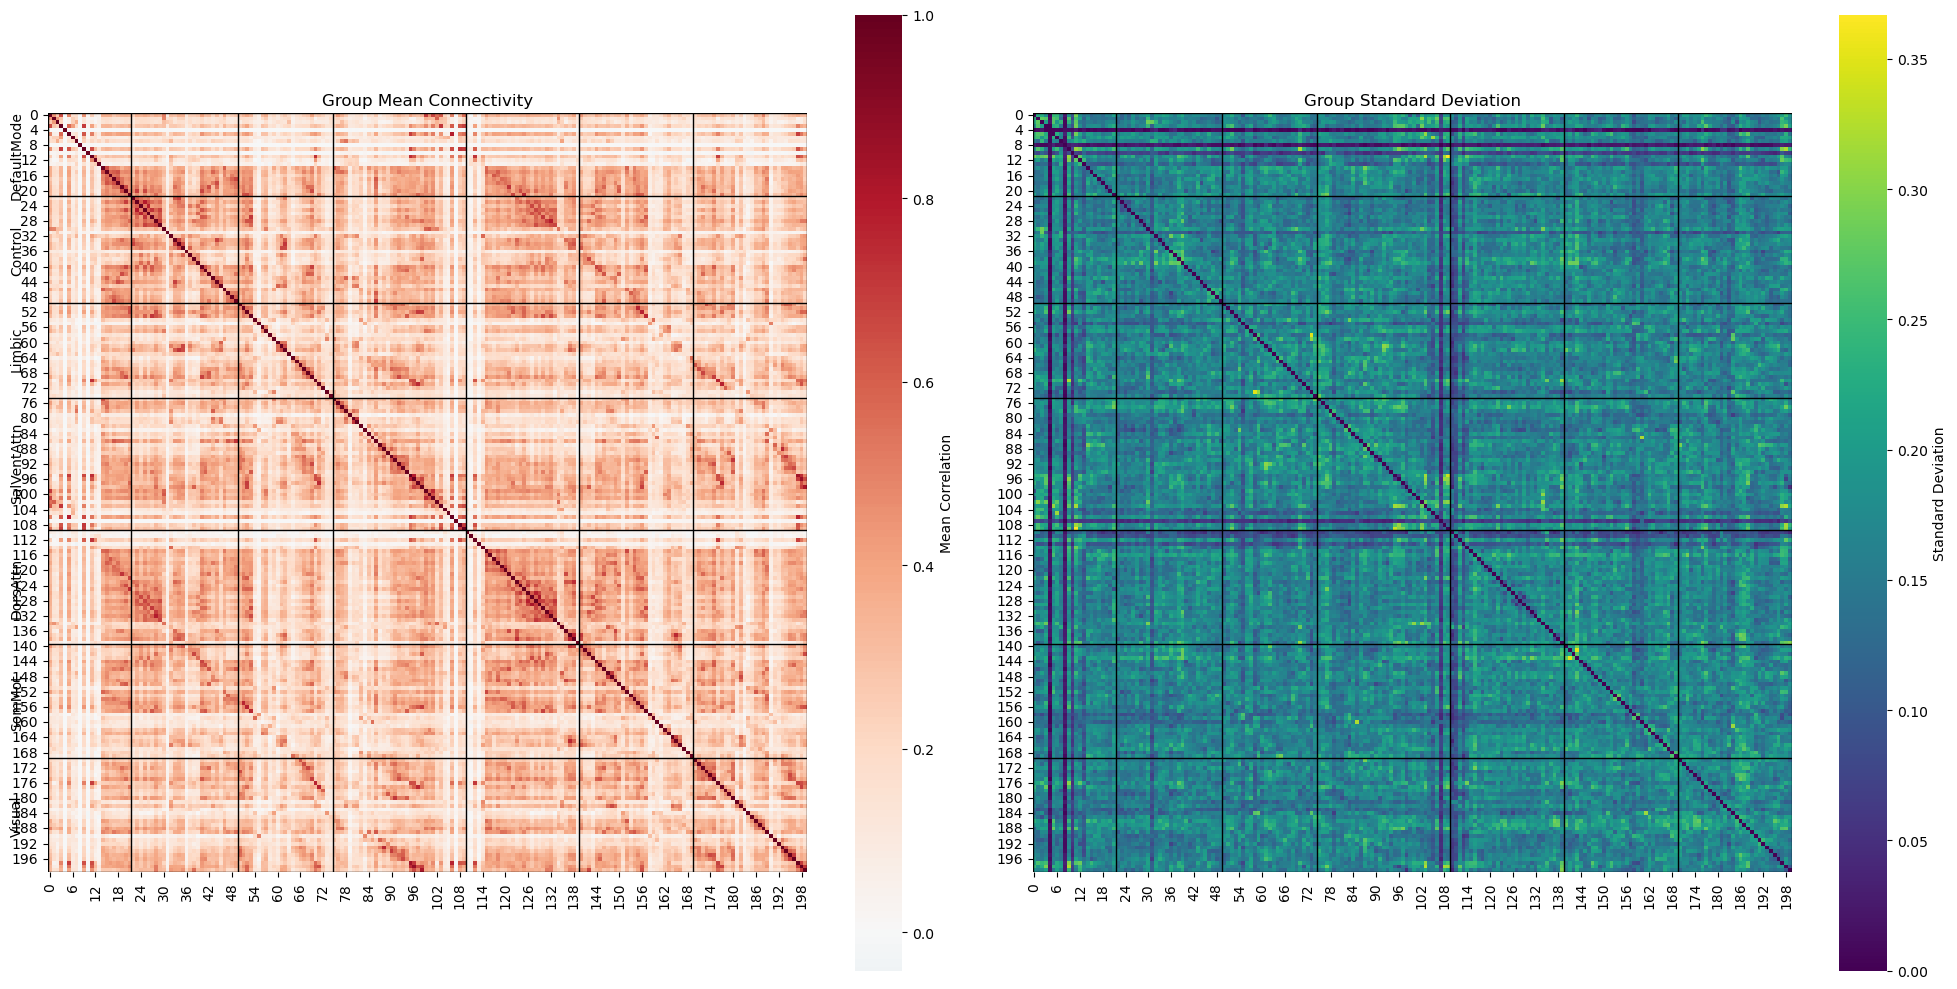


Network-wise Statistics:
--------------------------------------------------

DefaultMode Network:
Within-network mean connectivity: 0.242 ± 0.139

Connectivity with other networks:
Control: 0.231 ± 0.149
Limbic: 0.186 ± 0.145
SalVentAttn: 0.215 ± 0.155
DorsAttn: 0.225 ± 0.150
SomMot: 0.199 ± 0.145
Visual: 0.196 ± 0.147

Control Network:
Within-network mean connectivity: 0.350 ± 0.158

Connectivity with other networks:
DefaultMode: 0.231 ± 0.149
Limbic: 0.242 ± 0.159
SalVentAttn: 0.244 ± 0.159
DorsAttn: 0.291 ± 0.161
SomMot: 0.255 ± 0.162
Visual: 0.239 ± 0.158

Limbic Network:
Within-network mean connectivity: 0.259 ± 0.166

Connectivity with other networks:
DefaultMode: 0.186 ± 0.145
Control: 0.242 ± 0.159
SalVentAttn: 0.230 ± 0.166
DorsAttn: 0.217 ± 0.155
SomMot: 0.219 ± 0.162
Visual: 0.236 ± 0.163

SalVentAttn Network:
Within-network mean connectivity: 0.267 ± 0.162

Connectivity with other networks:
DefaultMode: 0.215 ± 0.155
Control: 0.244 ± 0.159
Limbic: 0.230 ± 0.166
DorsAttn: 0

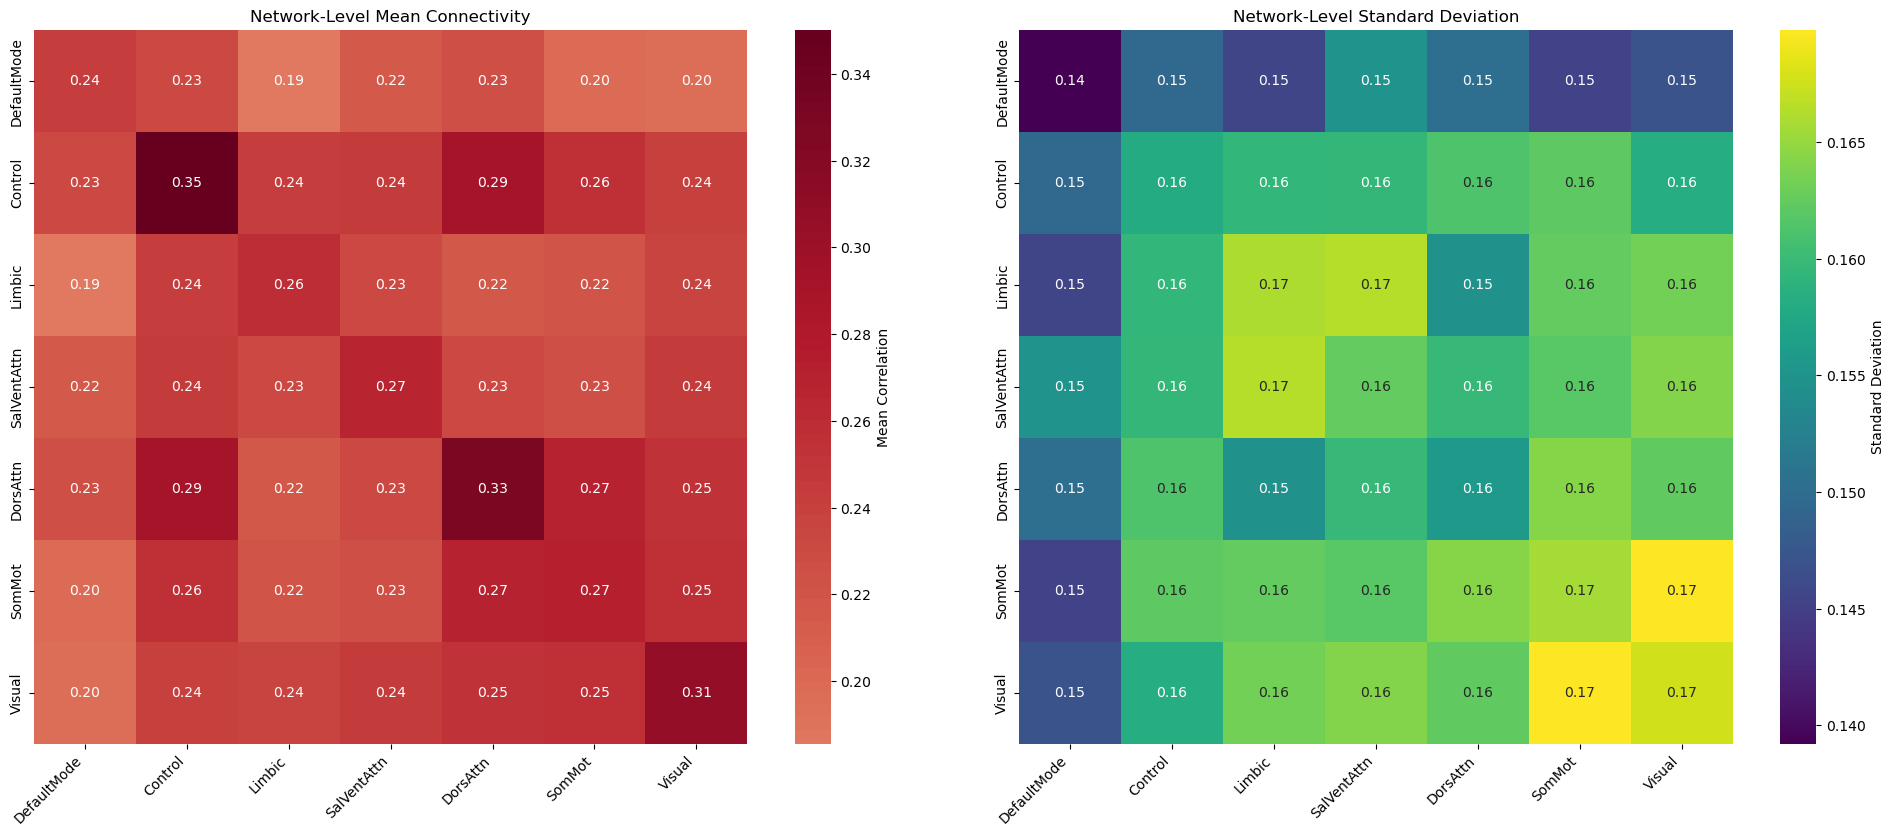

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

def analyze_networks():
    # Load matrices
    mean_matrix = np.load('/user_data/csimmon2/git_repos/ptoc/results/connectivity_data/group_mean_matrix.npy')
    std_matrix = np.load('/user_data/csimmon2/git_repos/ptoc/results/connectivity_data/group_std_matrix.npy')

    # Network boundaries and labels
    networks = [0, 22, 50, 75, 110, 140, 170, 200]
    network_labels = [
        'DefaultMode',
        'Control',
        'Limbic',
        'SalVentAttn',
        'DorsAttn',
        'SomMot',
        'Visual'
    ]

    # Create figure with subplots for mean and std matrices
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

    # Plot mean matrix
    sns.heatmap(mean_matrix, 
                cmap='RdBu_r',
                center=0,
                square=True,
                ax=ax1,
                cbar_kws={'label': 'Mean Correlation'})
    ax1.set_title('Group Mean Connectivity')
    
    # Add network boundaries to mean matrix
    for idx in networks:
        ax1.axhline(y=idx, color='black', linewidth=1)
        ax1.axvline(x=idx, color='black', linewidth=1)
    
    # Add network labels to mean matrix
    for i in range(len(networks)-1):
        mid_point = (networks[i] + networks[i+1]) // 2
        ax1.text(-10, mid_point, network_labels[i],
                rotation=90, verticalalignment='center')

    # Plot std matrix
    sns.heatmap(std_matrix, 
                cmap='viridis',
                square=True,
                ax=ax2,
                cbar_kws={'label': 'Standard Deviation'})
    ax2.set_title('Group Standard Deviation')
    
    # Add network boundaries to std matrix
    for idx in networks:
        ax2.axhline(y=idx, color='black', linewidth=1)
        ax2.axvline(x=idx, color='black', linewidth=1)
    
    plt.tight_layout()
    plt.show()

    # Calculate and display network-wise statistics
    print("\nNetwork-wise Statistics:")
    print("-" * 50)
    for i in range(len(networks)-1):
        network_name = network_labels[i]
        start_idx = networks[i]
        end_idx = networks[i+1]
        
        # Within-network connectivity
        within_mean = mean_matrix[start_idx:end_idx, start_idx:end_idx].mean()
        within_std = std_matrix[start_idx:end_idx, start_idx:end_idx].mean()
        
        print(f"\n{network_name} Network:")
        print(f"Within-network mean connectivity: {within_mean:.3f} ± {within_std:.3f}")
        
        # Between-network connectivity
        print("\nConnectivity with other networks:")
        for j in range(len(networks)-1):
            if i != j:
                other_name = network_labels[j]
                other_start = networks[j]
                other_end = networks[j+1]
                
                between_mean = mean_matrix[start_idx:end_idx, other_start:other_end].mean()
                between_std = std_matrix[start_idx:end_idx, other_start:other_end].mean()
                
                print(f"{other_name}: {between_mean:.3f} ± {between_std:.3f}")

    # Create network-level summary matrices
    network_means = np.zeros((len(network_labels), len(network_labels)))
    network_stds = np.zeros((len(network_labels), len(network_labels)))

    for i in range(len(networks)-1):
        for j in range(len(networks)-1):
            block_mean = mean_matrix[networks[i]:networks[i+1], networks[j]:networks[j+1]].mean()
            block_std = std_matrix[networks[i]:networks[i+1], networks[j]:networks[j+1]].mean()
            network_means[i,j] = block_mean
            network_stds[i,j] = block_std

    # Plot network-level summaries
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

    # Network-level mean connectivity
    sns.heatmap(network_means, 
                cmap='RdBu_r',
                center=0,
                square=True,
                ax=ax1,
                xticklabels=network_labels,
                yticklabels=network_labels,
                annot=True,
                fmt='.2f',
                cbar_kws={'label': 'Mean Correlation'})
    ax1.set_title('Network-Level Mean Connectivity')
    plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')

    # Network-level standard deviation
    sns.heatmap(network_stds, 
                cmap='viridis',
                square=True,
                ax=ax2,
                xticklabels=network_labels,
                yticklabels=network_labels,
                annot=True,
                fmt='.2f',
                cbar_kws={'label': 'Standard Deviation'})
    ax2.set_title('Network-Level Standard Deviation')
    plt.setp(ax2.get_xticklabels(), rotation=45, ha='right')

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    analyze_networks()